In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
import random
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)

## **Load the Data**

In [2]:
data = pd.read_csv('/content/bank-additional-full.csv')

In [3]:
data = data.drop_duplicates()
data.shape

(41176, 21)

In [4]:
data = data[data['job'] != 'unknown']
data = data[data['marital'] != 'unknown']
data = data[data['education'] != 'unknown']
data = data[data['default'] != 'unknown']
data = data[data['housing'] != 'unknown']
data = data[data['loan'] != 'unknown']
data = data[data['contact'] != 'unknown']
data = data[data['month'] != 'unknown']
data = data[data['day_of_week'] != 'unknown']
data = data[data['poutcome'] != 'unknown']

In [5]:
data['job'] = [0 if elem=='admin.' else 1 if elem=='blue-collar' else 2 if elem=='technician' else 3 if elem=='services' else 4 if elem=='management' else 5 if elem=='retired' else 6 if elem=='entrepreneur' else 7 if elem=='self-employed' else 8 if elem=='housemaid' else 9 if elem=='student' else 10 if elem=='unemployed' else 11 for elem in data['job']]
data['marital'] = [0 if elem=='married.' else 1 if elem=='single' else 2 if elem=='divorce' else 3 for elem in data['marital']]
data['education'] = [1 if elem=='university.degree' else 2 if elem=='high.school' else 3 if elem=='basic.9y' else 4 if elem=='professional.course' else 5 if elem=='basic.4y' else 6 if elem=='basic.6y' else 7 for elem in data['education']]
data['default'] = [1 if elem=='no' else 2 if elem=='yes' else 3 for elem in data['default']]
data['housing'] = [1 if elem=='no' else 2 if elem=='yes' else 3 for elem in data['housing']]
data['loan'] = [1 if elem=='no' else 2 if elem=='yes' else 3 for elem in data['loan']]
data['contact'] = [1 if elem=='cellular' else 2 for elem in data['contact']]
data['month'] = [0.5 if elem=='may' else 0.7 if elem=='jul' else 0.8 if elem=='aug' else 0.6 if elem=='jun' else 0.11 if elem=='nov' else 0.4 if elem=='apr' else 0.10 if elem=='oct' else 0.9 if elem=='sep' else 0.3 if elem=='mar' else 0.12 for elem in data['month']]
data['day_of_week'] = [0.10 if elem=='mon' else 0.40 if elem=='thu' else 0.30 if elem=='wed' else 0.20 if elem=='tue' else 0.50 for elem in data['day_of_week']]
data['poutcome'] = [1 if elem=='nonexistent' else 2 if elem=='failure' else 3 for elem in data['poutcome']]

In [6]:
data['y'] = [1 if elem=='no' else 0 for elem in data['y']]

In [7]:
data_no = data.loc[data['y']==1]
data_yes = data.loc[data['y']==0]

In [8]:
data_no_train = data_no[10000:25000]
data_no_test = data_no[:4000]
data_yes_train = data_yes[:3000]
data_yes_test = data_yes[3000:]

In [9]:
train = pd.DataFrame(pd.concat([data_no_train,data_yes_train]))
test = pd.DataFrame(pd.concat([data_no_test,data_yes_test]))

In [10]:
train = train.reset_index(drop = True)   #reset index for the train data
test = test.reset_index(drop = True)     #reset index for the test data

In [11]:
y_train = train['y']
y_test = test['y']

In [12]:
train = train.drop(['y'],axis=1)
test = test.drop(['y'],axis=1)

In [13]:
scaler = MinMaxScaler()
train = scaler.fit_transform(train)
train = np.array(train)
train = train / train.sum(axis=1, keepdims=True)
train = np.clip(train,0.0000005,None)

In [14]:
scaler = MinMaxScaler()
test = scaler.fit_transform(test)
test = np.array(test)
test = test / test.sum(axis=1, keepdims=True)
test = np.clip(test,0.0000005,None)

##**Parameter Estimaion**

In [15]:
def moment_initialization(data):
  mean = np.mean(data,axis=0)
  mean_square = np.mean(data**2,axis=0)
  alpha = np.zeros(data.shape[1])
  for k in range(data.shape[1]):
    alpha[k] = mean[k]*(mean[k]-mean_square[k])/(mean_square[k]-(mean[k])**2)
  return alpha

In [16]:
from scipy.special import gamma, digamma, gammaln, psi,polygamma
def log_lbl(row,theta):
  alpha_K, alpha, beta, lamda = theta[:len(theta)-3], theta[len(theta)-3], theta[len(theta)-2], theta[len(theta)-1]
  c = gammaln(np.sum(alpha_K)) + gammaln(alpha+beta) - gammaln(alpha) - gammaln(beta)
  q1 = (alpha-np.sum(alpha_K))*np.log(np.abs(1-np.mean(row))) + alpha*np.log(lamda)
  q2 = (alpha+beta)*np.log(np.abs(1-(1-lamda)*(1-np.mean(row)))) - (beta-1)*np.log(np.abs(np.mean(row)))
  q3 = np.sum(((alpha_K)-1)*np.log(row)) - np.sum(np.log(alpha_K))
  return c+q1+q2+q3

In [17]:
def normalize_theta(arr, m, M):
    min_val = min(arr)
    max_val = max(arr)
    normalized_arr = []

    for value in arr:
        normalized_value = m + ((value - min_val) * (M - m) / (max_val - min_val))
        normalized_arr.append(normalized_value)

    return normalized_arr

In [18]:
def calcul_inv_hess_vect(data,theta):
  alpha = theta[:len(theta)-3]
  (N, K) = data.shape
  q = N*float(polygamma(1,np.sum(alpha)))
  inv_S = np.diag([-N/np.clip(float(polygamma(1,alpha[m])),10**(-7),None) for m in range(K)])
  a = np.ones(K).reshape(-1,1)
  inv_hess = inv_S + np.dot(np.dot(inv_S,a),np.dot(np.transpose(a),inv_S))/((1/q)*np.dot(np.dot(np.transpose(a),inv_S),a))
  return inv_hess

In [19]:
def calcul_inv_hess_non_vect(data,theta):
  (N, K) = data.shape
  H = np.zeros((3,3))
  alpha, beta, lamda = theta[len(theta)-3], theta[len(theta)-2], theta[len(theta)-1]
  H[0][0] = N*(float(polygamma(1,alpha+beta)) - float(polygamma(1,alpha)))
  H[1][1] = N*(float(polygamma(1,alpha+beta)) - float(polygamma(1,beta)))
  H[2][2] = N*((alpha+beta) / ((1-(1-lamda))**2) - (alpha/(lamda**2)))
  H[0][1] = H[1][0] = N*float(polygamma(1,alpha+beta))
  H[0][2] = H[2][0] = N*((1/lamda) - (1/(1-(1-lamda))))
  H[1][2] = H[2][1] = -N*(1/(1-(1-lamda)))
  inv_H = np.linalg.inv(H)
  return inv_H

In [20]:
def derivative(data,theta_old):
  (N, K) = data.shape
  der_vect_alpha = np.zeros(K)
  vect_alpha_old, alpha_old, beta_old, lamda_old = theta_old[:len(theta_old)-3], theta_old[len(theta_old)-3], theta_old[len(theta_old)-2], theta_old[len(theta_old)-1]
  for s in range(K):
    der_vect_alpha[s] =N*(psi(np.sum(vect_alpha_old)) - psi(vect_alpha_old[s])) - np.sum(np.log(data[:,s]) )
  der_alpha = N*(psi(alpha_old+beta_old)-psi(alpha_old) + np.log(np.clip(lamda_old,10**(-6),None))-np.log(np.clip(1-(1-lamda_old),10**(-6),None)))
  der_beta = N*(psi(alpha_old+beta_old)-psi(beta_old)- np.log(np.clip(1-(1-lamda_old),10**(-8),None)))
  der_lamda = N*((alpha_old/lamda_old) - (alpha_old+beta_old)/(1-(1-lamda_old)))
  der_theta = np.concatenate((der_vect_alpha, der_alpha,der_beta, der_lamda), axis=None)
  return der_theta

In [21]:
def update_theta(data,theta_old):
  inv_hess_vect = calcul_inv_hess_vect(data,theta_old)
  inv_hess_non_vect = calcul_inv_hess_non_vect(data,theta_old)
  der_param = derivative(data,theta_old)

  vect_alpha_old, alpha_beta_lamda_old = theta_old[:len(theta_old)-3], theta_old[len(theta_old)-3:]
  der_vect_alpha_old, der_alpha_beta_lamda_old = der_param[:len(der_param)-3], der_param[len(der_param)-3:]

  vect_alpha_new = vect_alpha_old - np.dot(inv_hess_vect,der_vect_alpha_old)
  vect_alpha_new = normalize_theta(vect_alpha_new,0.1,2)
  alpha_beta_lamda_new = alpha_beta_lamda_old - np.dot(inv_hess_non_vect,der_alpha_beta_lamda_old)
  alpha_beta_lamda_new = normalize_theta(alpha_beta_lamda_new,0.1,2)
  theta_new = (np.clip(np.concatenate((vect_alpha_new,alpha_beta_lamda_new), axis=None),10**(-15),None))

  return theta_new

In [22]:
theta_zero =  [1.13087455, 0.73173886, 1.64559892, 1.88218278, 2.89396418, 2.24914742,
 4.94303181, 0.60001957, 1.1234961,  0.89041664, 3.30023079, 1.34112885,
 2.38492279, 1.2976854,  0.87895096, 0.64083819, 3.31601499, 0.77709646,
 1.06325357, 1.90675334, 4.12286683, 0.57579625, 4.20593005]

In [23]:
'''#theta_zero = np.concatenate((moment_initialization(train),np.random.uniform(low=0.1, high=1, size=(3,))), axis=None)
theta_zero = np.random.uniform(low=0.1, high=5, size=(train.shape[1]+3,))
print('theta_zero = ',np.array(theta_zero))'''
theta_old = theta_zero

In [24]:
max_iter = 5
for j in range(max_iter):
  theta_new = update_theta(train,theta_old)
  theta_old = theta_new

##**Feature mapping**

In [25]:
train_df = pd.DataFrame(train)
#train_df['new_feature'] = normalize_theta([log_lbl(row,theta_new) for row in train],10,20)
train_df['new_feature'] = [log_lbl(row,theta_new) for row in train]

test_df = pd.DataFrame(test)
#test_df['new_feature'] = normalize_theta([log_lbl(row,theta_new) for row in test],10,20)
test_df['new_feature'] = [log_lbl(row,theta_new) for row in test]

In [26]:
train_f = np.array(train_df)
test_f = np.array(test_df)

In [27]:
from sklearn.svm import SVC
# Train SVM classifier
print("Training SVM classifier...")
svm = SVC(kernel='linear', C=5.0, gamma='auto', random_state=42)
svm.fit(train_f, y_train)

Training SVM classifier...


SVC(C=5.0, gamma='auto', kernel='linear', random_state=42)

In [28]:
# Test SVM classifier
print("Testing SVM classifier...")
y_pred_svm = svm.predict(test_f)

Testing SVM classifier...


In [29]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, accuracy_score
from sklearn import metrics
# Evaluate the performance of the classifier
print("F1 Score:", f1_score(y_test, y_pred_svm))
print("Precision:", precision_score(y_test, y_pred_svm))
print("Recall:", recall_score(y_test, y_pred_svm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))
print("Accuracy:", accuracy_score(y_test, y_pred_svm))

F1 Score: 0.9584689493555527
Precision: 1.0
Recall: 0.92025
Confusion Matrix:
 [[ 858    0]
 [ 319 3681]]
Accuracy: 0.9343351173322355


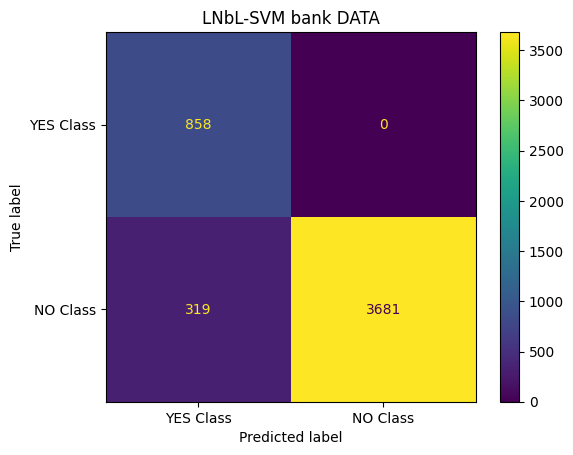

In [31]:
cm = confusion_matrix(y_test, y_pred_svm)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['YES Class', 'NO Class'])
cm_display.plot()
cm_display.ax_.set_title('LNbL-SVM bank DATA')
plt.show()